# Global Green Energy Analysis 🌱

Today we're diving into global renewable energy data to uncover patterns in how countries are transitioning to clean electricity. This analysis will take us from simple rankings to more sophisticated clustering techniques to group countries by their renewable energy trajectories.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load in data
raw_data = pd.read_csv('global_sustainable_energy_data.csv')

In [8]:
raw_data.sample(4)
raw_data.info()

# data looks good, let's visuailise it. 
df = raw_data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 21 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            3649 non-null   object 
 1   Year                                                              3649 non-null   int64  
 2   Access to electricity (% of population)                           3639 non-null   float64
 3   Access to clean fuels for cooking                                 3480 non-null   float64
 4   Renewable-electricity-generating-capacity-per-capita              2718 non-null   float64
 5   Financial flows to developing countries (US $)                    1560 non-null   float64
 6   Renewable energy share in the total final energy consumption (%)  3455 non-null   float64
 7   Electricity from fossil fuels (TW

## First Look at the Data

Two key observations emerge from our initial exploration:
- **Data quality looks solid** - clean structure with country-year observations and our target renewable electricity variable is well-populated across the dataset
- **Scale varies dramatically** - the raw numbers hint at massive differences between countries, which makes sense given population and economic disparities, but suggests we'll need smart normalization approaches later

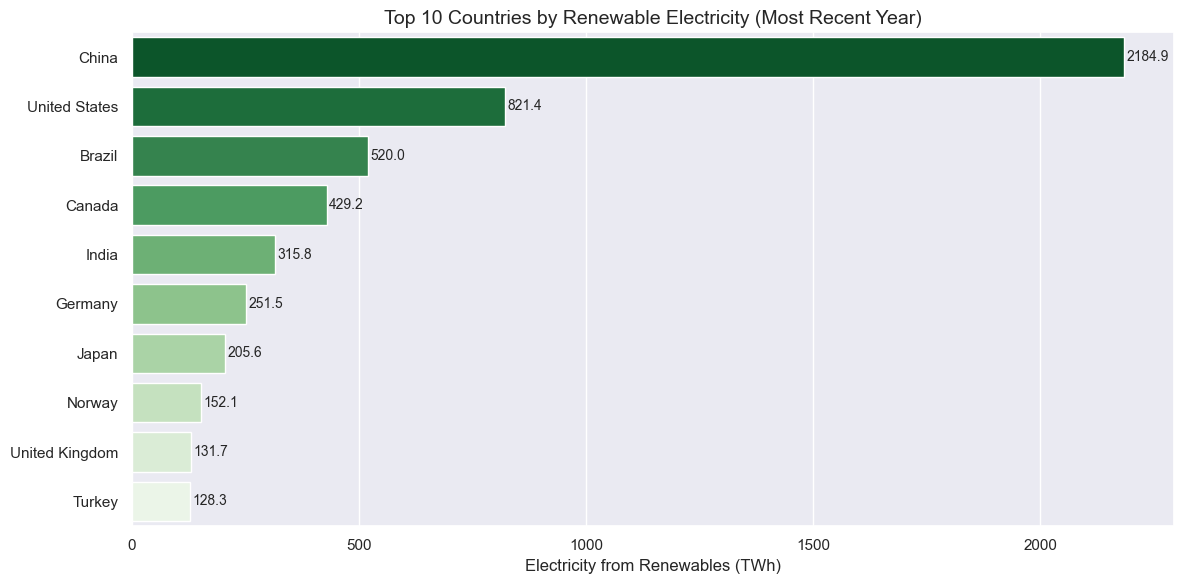

In [25]:
# only look at green energy data
df_clean = df.dropna(subset=['Electricity from renewables (TWh)'])

# get latest year and top 10 countries
latest = df_clean.sort_values('Year').groupby('Entity').tail(1)
top10 = latest.sort_values("Electricity from renewables (TWh)", ascending=False).head(10)

# plot it

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top10,
    x="Electricity from renewables (TWh)",
    y="Entity",
    palette=sns.color_palette("Greens", n_colors=10)[::-1],  # reverse order
    hue="Entity",
)

# Annotate bars
for i, value in enumerate(top10["Electricity from renewables (TWh)"]):
    ax.text(value + 5, i, f"{value:.1f}", va='center', fontsize=10)

plt.title("Top 10 Countries by Renewable Electricity (Most Recent Year)", fontsize=14)
plt.xlabel("Electricity from Renewables (TWh)")
plt.ylabel("")
plt.tight_layout()
plt.show()



## Initial Insights

Two patterns emerge from the renewable electricity rankings:
- **Scale dominance** - China's massive lead reflects both population size and serious renewable investment, showing how national capacity matters as much as policy commitment
- **Diverse adoption paths** - seeing Brazil and India alongside European leaders suggests the renewable transition isn't limited to wealthy nations - different economic models can drive green energy growth

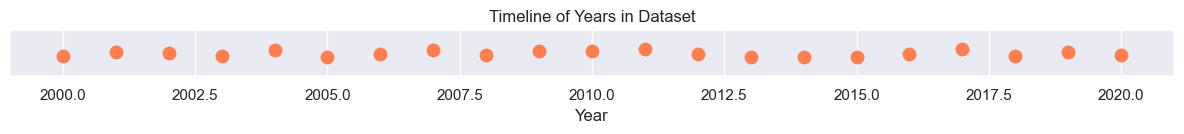

In [33]:
# how many years does the dataset cover?
plt.figure(figsize=(12, 1.5))
sns.stripplot(x=years, orient="h", size=10, color="coral")
plt.yticks([])
plt.title("Timeline of Years in Dataset")
plt.xlabel("Year")
plt.tight_layout()
plt.show()

## Setting Up the Time Dimension

Before diving into trends, let's understand our temporal scope:
- **Coverage matters** - we need sufficient historical data to identify meaningful patterns in renewable adoption trajectories 
- **Context alignment** - the timeframe should capture the modern renewable energy boom to be relevant for current policy discussions

## Data Coverage Check

Two encouraging findings about our temporal scope:
- **Sufficient depth** - roughly two decades of data gives us enough history to spot genuine trends versus short-term fluctuations in renewable adoption
- **Strategic timing** - this timeframe captures the renewable acceleration that really took off in the 2010s, making our analysis relevant to current energy transition discussions

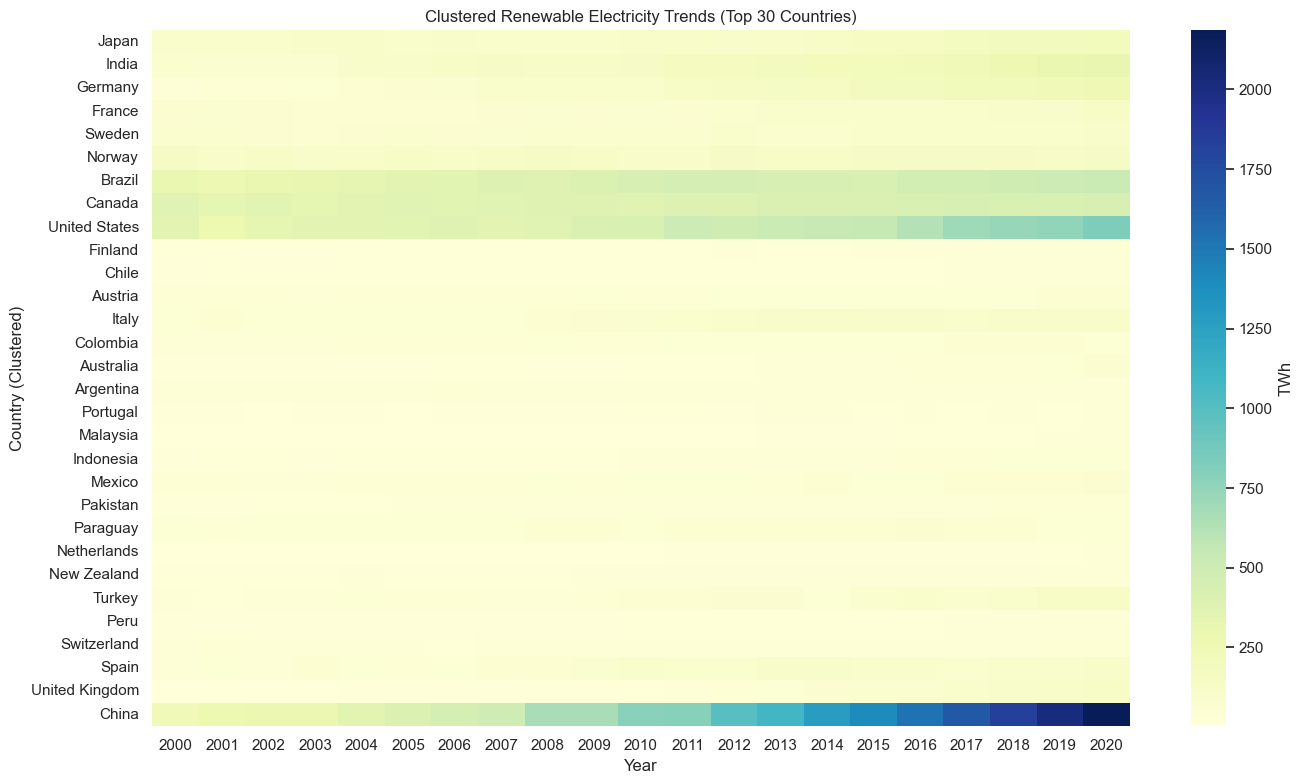

In [50]:
# Get top 12 countries by renewables in latest year
top_entities = (
    df_clean[df_clean["Year"] == latest_year]
    .sort_values("Electricity from renewables (TWh)", ascending=False)
    .head(12)["Entity"]
    .tolist()
)

# Filter to just top 12 entities
df_top = df_clean[df_clean["Entity"].isin(top_entities)]

# Reorder legend by last-year values
order_by_latest = (
    df_top[df_top["Year"] == latest_year]
    .groupby("Entity")["Electricity from renewables (TWh)"]
    .sum()
    .sort_values(ascending=False)
    .index.tolist()
)

# Plot heatmap of trends grouped by cluster
pivot_sorted = pivot.sort_values("Cluster").drop(columns=["Cluster"])

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_sorted, cmap="YlGnBu", cbar_kws={"label": "TWh"})
plt.title("Clustered Renewable Electricity Trends (Top 30 Countries)")
plt.xlabel("Year")
plt.ylabel("Country (Clustered)")
plt.tight_layout()
plt.show()



## Shifting to Pattern Recognition

Simple rankings only tell us who's at the top right now. Let's get smarter about this - by clustering countries based on their renewable energy growth patterns over time, we can identify different "types" of green energy adopters and see which trajectory each country follows.

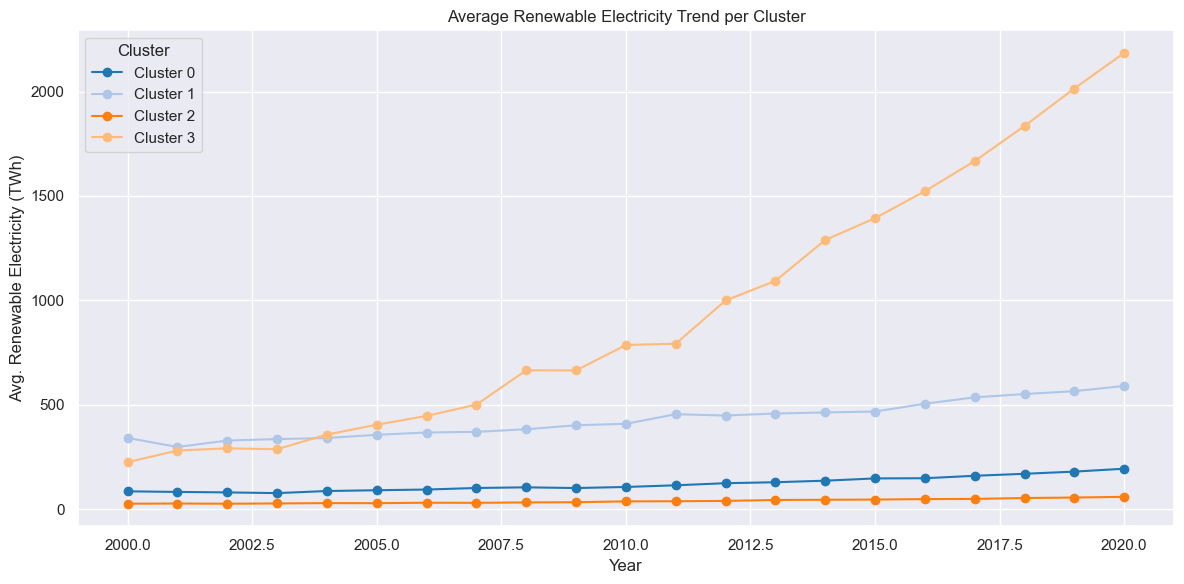

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Top 30 countries by latest year
latest_year = df_clean["Year"].max()
top_countries = (
    df_clean[df_clean["Year"] == latest_year]
    .sort_values("Electricity from renewables (TWh)", ascending=False)
    .head(30)["Entity"]
    .tolist()
)

# Filter and pivot
df_top = df_clean[df_clean["Entity"].isin(top_countries)]
pivot = df_top.pivot(index="Entity", columns="Year", values="Electricity from renewables (TWh)").fillna(0)

# Normalize per country
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot)

# Run clustering
k = 4  # Change cluster count as needed
kmeans = KMeans(n_clusters=k, random_state=42)
pivot['Cluster'] = kmeans.fit_predict(X_scaled)

# Merge cluster labels back
pivot_no_cluster = pivot.drop(columns=["Cluster"])
pivot_no_cluster["Cluster"] = kmeans.labels_

# Group by cluster and average
cluster_means = pivot_no_cluster.groupby("Cluster").mean()

# Plot average trend per cluster
plt.figure(figsize=(12, 6))
for cluster_id, row in cluster_means.iterrows():
    plt.plot(row.index, row.values, marker='o', label=f"Cluster {cluster_id}")

plt.title("Average Renewable Electricity Trend per Cluster")
plt.xlabel("Year")
plt.ylabel("Avg. Renewable Electricity (TWh)")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()



## Clustering Reveals Hidden Patterns

The clustering approach unlocks insights that simple rankings miss entirely:
- **Trajectory typing** - each cluster represents a distinct renewable adoption pathway, revealing that countries don't just differ in scale but in their fundamental growth patterns over time
- **Beyond current leaders** - clustering shows us which countries are on similar paths regardless of their current position, helping identify emerging leaders before they reach the top rankings
- **Policy implications** - understanding these different trajectories helps policymakers see which approach their country is following and what lessons they can learn from cluster peers
- **Predictive power** - by identifying which cluster a country belongs to, we can better anticipate future renewable development patterns and set more realistic targets